In [4]:
# Initial Imports

import os
import requests
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import alpaca_trade_api as tradeapi
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report


# Import the hvPlot library
import hvplot.pandas
import matplotlib.pyplot as plt

In [5]:
# Load .env environment variables
load_dotenv()

True

In [6]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [7]:
# Confirm Alpaca key and secret were correctly loaded
print(f'Alpaca Key Type: {type(alpaca_api_key)}')
print(f'Alpaca Secret Key Type: {type(alpaca_secret_key)}')

Alpaca Key Type: <class 'str'>
Alpaca Secret Key Type: <class 'str'>


In [8]:
#Create the Alpaca API object
alpaca_aapl = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [9]:
# Format start and end date as ISO format for 5-year period historical period
start = pd.Timestamp('2018-09-01', tz='America/New_York').isoformat()
end = pd.Timestamp('2023-08-31', tz='America/New_York').isoformat()


In [10]:
# Set the tickers
tickers = ['AAPL']

In [11]:
# Set timeframe to one day ("1Day") for the Alpaca API
timeframe = '1Day'

In [12]:
# Retreive the closing prices for Apple
df_aapl = alpaca_aapl.get_bars(
    tickers, 
    timeframe,
    start = start,
    end = end
).df

In [13]:
# Display sample display
df_aapl.head()
df_aapl.tail()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2023-08-25 04:00:00+00:00,177.380,179.15,175.820,178.61,50888986,547380,177.911565,AAPL
2023-08-28 04:00:00+00:00,180.090,180.59,178.545,180.19,43873741,533512,179.659469,AAPL
2023-08-29 04:00:00+00:00,179.695,184.90,179.500,184.12,53097997,577653,183.281403,AAPL
2023-08-30 04:00:00+00:00,184.940,187.85,184.740,187.65,60851143,637412,186.930379,AAPL
2023-08-31 04:00:00+00:00,187.840,189.12,187.480,187.87,60794516,554869,188.148910,AAPL


In [14]:
# Filter the date index and close columns
aapl_signals_df = df_aapl.loc[:, ['close']]

aapl_signals_df["Actual_Returns"] = aapl_signals_df["close"].pct_change()

# Drop all the NaN values from the DataFrame
aapl_signals_df = aapl_signals_df.dropna()

# Review the DataFrame
display(aapl_signals_df.head())
display(aapl_signals_df.tail())

,close,Actual_Returns
timestamp,,
2018-09-05 04:00:00+00:00,226.87,-0.006525
2018-09-06 04:00:00+00:00,223.10,-0.016617
2018-09-07 04:00:00+00:00,221.30,-0.008068
2018-09-10 04:00:00+00:00,218.33,-0.013421
2018-09-11 04:00:00+00:00,223.85,0.025283


,close,Actual_Returns
timestamp,,
2023-08-25 04:00:00+00:00,178.61,0.012643
2023-08-28 04:00:00+00:00,180.19,0.008846
2023-08-29 04:00:00+00:00,184.12,0.021810
2023-08-30 04:00:00+00:00,187.65,0.019172
2023-08-31 04:00:00+00:00,187.87,0.001172


In [113]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
aapl_signals_df['SMA_Fast'] = aapl_signals_df['close'].rolling(window=short_window).mean()
aapl_signals_df['SMA_Slow'] = aapl_signals_df['close'].rolling(window=long_window).mean()

aapl_signals_df = aapl_signals_df.dropna()

# Review the DataFrame
display(aapl_signals_df.head())
display(aapl_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2019-05-09 04:00:00+00:00,200.72,-0.010744,203.740,177.4486,-1.0,-0.010744,0.174144
2019-05-10 04:00:00+00:00,197.18,-0.017637,200.915,177.7656,-1.0,0.017637,0.153437
2019-05-13 04:00:00+00:00,185.72,-0.058119,196.630,177.9834,-1.0,0.058119,0.086400
2019-05-14 04:00:00+00:00,188.66,0.015830,193.070,178.2093,1.0,-0.015830,0.103598
2019-05-15 04:00:00+00:00,190.92,0.011979,190.620,178.5096,1.0,0.011979,0.116818


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2023-08-25 04:00:00+00:00,178.61,0.012643,178.3350,179.1083,1.0,-0.012643,0.044808
2023-08-28 04:00:00+00:00,180.19,0.008846,179.0750,179.2539,1.0,0.008846,0.054051
2023-08-29 04:00:00+00:00,184.12,0.021810,179.8250,179.4575,1.0,0.021810,0.077040
2023-08-30 04:00:00+00:00,187.65,0.019172,182.6425,179.6874,1.0,0.019172,0.097689
2023-08-31 04:00:00+00:00,187.87,0.001172,184.9575,179.9458,1.0,0.001172,0.098976


In [114]:
# Initialize the new Signal column
aapl_signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
aapl_signals_df.loc[(aapl_signals_df['Actual_Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
aapl_signals_df.loc[(aapl_signals_df['Actual_Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(aapl_signals_df.head())
display(aapl_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2019-05-09 04:00:00+00:00,200.72,-0.010744,203.740,177.4486,-1.0,-0.010744,0.174144
2019-05-10 04:00:00+00:00,197.18,-0.017637,200.915,177.7656,-1.0,0.017637,0.153437
2019-05-13 04:00:00+00:00,185.72,-0.058119,196.630,177.9834,-1.0,0.058119,0.086400
2019-05-14 04:00:00+00:00,188.66,0.015830,193.070,178.2093,1.0,-0.015830,0.103598
2019-05-15 04:00:00+00:00,190.92,0.011979,190.620,178.5096,1.0,0.011979,0.116818


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2023-08-25 04:00:00+00:00,178.61,0.012643,178.3350,179.1083,1.0,-0.012643,0.044808
2023-08-28 04:00:00+00:00,180.19,0.008846,179.0750,179.2539,1.0,0.008846,0.054051
2023-08-29 04:00:00+00:00,184.12,0.021810,179.8250,179.4575,1.0,0.021810,0.077040
2023-08-30 04:00:00+00:00,187.65,0.019172,182.6425,179.6874,1.0,0.019172,0.097689
2023-08-31 04:00:00+00:00,187.87,0.001172,184.9575,179.9458,1.0,0.001172,0.098976


In [115]:
# Identify the instances
aapl_signals_df['Signal'].value_counts()

 1.0    574
-1.0    513
Name: Signal, dtype: int64

In [116]:
# Calculate the strategy returns and add them to the signals_df DataFrame
aapl_signals_df['Strategy_Returns'] = aapl_signals_df['Actual_Returns'] * aapl_signals_df['Signal'].shift()

# Review the DataFrame
display(aapl_signals_df.head())
display(aapl_signals_df.tail())

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2019-05-09 04:00:00+00:00,200.72,-0.010744,203.740,177.4486,-1.0,NaN,0.174144
2019-05-10 04:00:00+00:00,197.18,-0.017637,200.915,177.7656,-1.0,0.017637,0.153437
2019-05-13 04:00:00+00:00,185.72,-0.058119,196.630,177.9834,-1.0,0.058119,0.086400
2019-05-14 04:00:00+00:00,188.66,0.015830,193.070,178.2093,1.0,-0.015830,0.103598
2019-05-15 04:00:00+00:00,190.92,0.011979,190.620,178.5096,1.0,0.011979,0.116818


,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2023-08-25 04:00:00+00:00,178.61,0.012643,178.3350,179.1083,1.0,-0.012643,0.044808
2023-08-28 04:00:00+00:00,180.19,0.008846,179.0750,179.2539,1.0,0.008846,0.054051
2023-08-29 04:00:00+00:00,184.12,0.021810,179.8250,179.4575,1.0,0.021810,0.077040
2023-08-30 04:00:00+00:00,187.65,0.019172,182.6425,179.6874,1.0,0.019172,0.097689
2023-08-31 04:00:00+00:00,187.87,0.001172,184.9575,179.9458,1.0,0.001172,0.098976


In [117]:
# Add column for Cumulative Returns
aapl_signals_df['Cumulative_Returns'] = (1 + aapl_signals_df['Actual_Returns']).cumprod() - 1

aapl_signals_df.head(20)

,close,Actual_Returns,SMA_Fast,SMA_Slow,Signal,Strategy_Returns,Cumulative_Returns
timestamp,,,,,,,
2019-05-09 04:00:00+00:00,200.72,-0.010744,203.7400,177.4486,-1.0,NaN,-0.010744
2019-05-10 04:00:00+00:00,197.18,-0.017637,200.9150,177.7656,-1.0,0.017637,-0.028191
2019-05-13 04:00:00+00:00,185.72,-0.058119,196.6300,177.9834,-1.0,0.058119,-0.084672
2019-05-14 04:00:00+00:00,188.66,0.015830,193.0700,178.2093,1.0,-0.015830,-0.070182
2019-05-15 04:00:00+00:00,190.92,0.011979,190.6200,178.5096,1.0,0.011979,-0.059044
2019-05-16 04:00:00+00:00,190.08,-0.004400,188.8450,178.8421,-1.0,-0.004400,-0.063184
2019-05-17 04:00:00+00:00,189.00,-0.005682,189.6650,179.2248,-1.0,0.005682,-0.068507
2019-05-20 04:00:00+00:00,183.09,-0.031270,188.2725,179.5874,-1.0,0.031270,-0.097634
2019-05-21 04:00:00+00:00,186.60,0.019171,187.1925,179.8817,1.0,-0.019171,-0.080335


<Axes: xlabel='timestamp'>

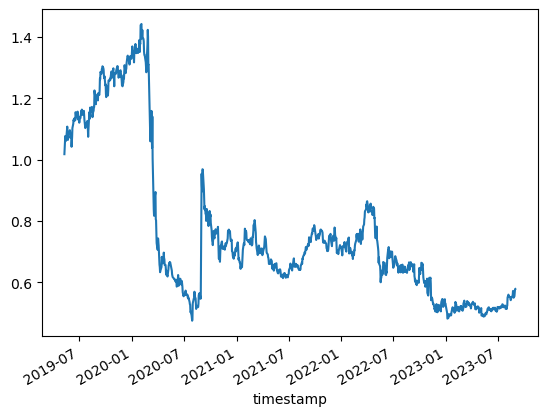

In [118]:
# Plot Strategy Returns to examine performance
(1 + aapl_signals_df['Strategy_Returns']).cumprod().plot()

In [119]:
# Split the data into training and testing datasets
# Assign a copy of the sma_fast and sma_slow columns to features DataDrame called x
X = aapl_signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna().copy()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
timestamp,,
2019-05-10 04:00:00+00:00,203.740,177.4486
2019-05-13 04:00:00+00:00,200.915,177.7656
2019-05-14 04:00:00+00:00,196.630,177.9834
2019-05-15 04:00:00+00:00,193.070,178.2093
2019-05-16 04:00:00+00:00,190.620,178.5096


In [120]:
# Create the target set selecting the Signal column and assigning it a y
y = aapl_signals_df['Signal'].copy()

# Review the value counts
y.value_counts()

 1.0    574
-1.0    513
Name: Signal, dtype: int64

In [121]:
# Select the start of the training period
training_begin = X.index.min() 

# Display the training begin date
print(training_begin)

2019-05-10 04:00:00+00:00


In [122]:
# Select the ending period for training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-08-10 04:00:00+00:00


In [123]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2019-08-05 04:00:00+00:00,208.5675,196.4853
2019-08-06 04:00:00+00:00,204.7075,196.6016
2019-08-07 04:00:00+00:00,200.6975,196.7343
2019-08-08 04:00:00+00:00,198.3500,196.8635
2019-08-09 04:00:00+00:00,198.2025,197.0176


In [124]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2023-08-25 04:00:00+00:00,177.6425,178.9839
2023-08-28 04:00:00+00:00,178.3350,179.1083
2023-08-29 04:00:00+00:00,179.0750,179.2539
2023-08-30 04:00:00+00:00,179.8250,179.4575
2023-08-31 04:00:00+00:00,182.6425,179.6874


In [125]:
# Scale the features DataFrames
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [126]:
# Using the SVC Classifier Model from SKLeans Support Vector Machine (SVM) Learning Method to fit the training data and make predictions based on the testing data. 
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred_training = svm_model.predict(X_train_scaled)
svm_pred_testing = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred_testing[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.])

In [127]:
# Review the classification Report associated with the SVC Models
# Use a classification report to evaluate the model using the predictions and testing data
svm_training_report = classification_report(y_train, svm_pred_training)

# Print the classification report
print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.63      0.91      0.75        34
         1.0       0.80      0.40      0.53        30

    accuracy                           0.67        64
   macro avg       0.72      0.66      0.64        64
weighted avg       0.71      0.67      0.65        64



In [128]:
# Backtesting SVM 
svm_testing_signal_predictions = svm_model.predict(X_test_scaled)

# Evalulate the model's ability to predict the training signal for the testing data
testing_report = classification_report(y_test, svm_testing_signal_predictions)

#Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      1.00      0.64       478
         1.0       0.71      0.01      0.02       544

    accuracy                           0.47      1022
   macro avg       0.59      0.50      0.33      1022
weighted avg       0.60      0.47      0.31      1022



In [129]:
# Create a predictions DataFrame that contains columns for "Predicted" and "Actual Returns" and Strategy Returns"
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted_Signal'] = svm_testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = aapl_signals_df['Actual_Returns']

# Add the strategy returns to the DataFrame
predictions_df['SVM_Trading_Algorithm_Returns'] = predictions_df['Actual_Returns'] * predictions_df['Predicted_Signal']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted_Signal,Actual_Returns,SVM_Trading_Algorithm_Returns
timestamp,,,
2019-08-12 04:00:00+00:00,1.0,-0.002537,-0.002537
2019-08-13 04:00:00+00:00,1.0,0.000000,0.000000
2019-08-14 04:00:00+00:00,1.0,0.011323,0.011323
2019-08-15 04:00:00+00:00,1.0,-0.004982,-0.004982
2019-08-16 04:00:00+00:00,1.0,0.023595,0.023595


,Predicted_Signal,Actual_Returns,SVM_Trading_Algorithm_Returns
timestamp,,,
2023-08-25 04:00:00+00:00,-1.0,0.012643,-0.012643
2023-08-28 04:00:00+00:00,-1.0,0.008846,-0.008846
2023-08-29 04:00:00+00:00,-1.0,0.021810,-0.021810
2023-08-30 04:00:00+00:00,-1.0,0.019172,-0.019172
2023-08-31 04:00:00+00:00,-1.0,0.001172,-0.001172


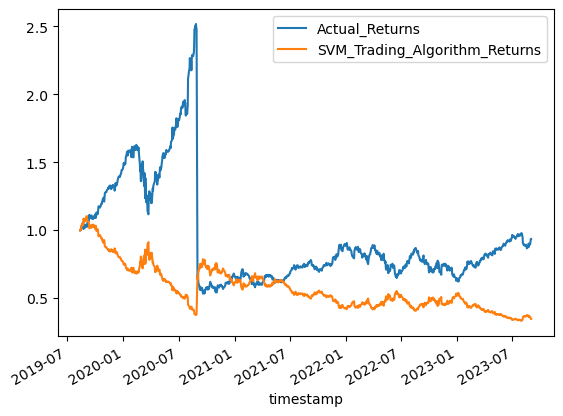

In [130]:
# Create a cumulative return plot that displays actual vs. strategy; this will serve as the baseline to compare the effects of tunning the algorithm
cum_return_plot = (1 + predictions_df[['Actual_Returns', 'SVM_Trading_Algorithm_Returns']]).cumprod().plot()
 
# Save figure
cum_return_plot.get_figure().savefig("AAPL_Cumulative_Returns_Comparison.png")

In [131]:
# Tune the Baseline and Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression 

# Initiate the model instance
logistic_regression_model = LogisticRegression()

In [132]:
# Using the original training data as the baseline, fit the model with Logistics Regression
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [133]:
# Use the testing dataset to generate the predictions for the new model
lr_pred_train_signals = logistic_regression_model.predict(X_train_scaled)

# Review the model's predicted values
lr_pred_train_signals

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.])

In [134]:
# Generate a classification report using the training data and the logistics regression model's predictions
lr_training_report = classification_report(y_train, lr_pred_train_signals)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.60      0.85      0.71        34
         1.0       0.69      0.37      0.48        30

    accuracy                           0.62        64
   macro avg       0.65      0.61      0.59        64
weighted avg       0.64      0.62      0.60        64



In [135]:
# Backtest the new model to evaluate performance 
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_signal_predict = logistic_regression_model.predict(X_test_scaled)

# Generate the classification report 
lr_testing_report = classification_report(y_test, lr_testing_signal_predict)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.70      0.57       478
         1.0       0.57      0.35      0.44       544

    accuracy                           0.51      1022
   macro avg       0.53      0.53      0.51      1022
weighted avg       0.53      0.51      0.50      1022



In [136]:
# Create a new empty predictions DataFrame:
lr_predict_df = pd.DataFrame(index=X_test.index)

# Add the Logistic Regression model predictions to the DataFrame
lr_predict_df['Predicted'] = lr_testing_signal_predict

# Add the actual returns to the DataFrame
lr_predict_df['Actual_Returns'] = aapl_signals_df['Actual_Returns']

# Add the strategy returns to the DataFrame
lr_predict_df['Logistics_Regression_Algo_Trading_Returns'] = lr_predict_df['Actual_Returns'] * lr_predict_df['Predicted']

# Review the DataFrame
display(lr_predict_df.head())
display(lr_predict_df.tail())

,Predicted,Actual_Returns,Logistics_Regression_Algo_Trading_Returns
timestamp,,,
2019-08-12 04:00:00+00:00,1.0,-0.002537,-0.002537
2019-08-13 04:00:00+00:00,1.0,0.000000,0.000000
2019-08-14 04:00:00+00:00,1.0,0.011323,0.011323
2019-08-15 04:00:00+00:00,1.0,-0.004982,-0.004982
2019-08-16 04:00:00+00:00,1.0,0.023595,0.023595


,Predicted,Actual_Returns,Logistics_Regression_Algo_Trading_Returns
timestamp,,,
2023-08-25 04:00:00+00:00,1.0,0.012643,0.012643
2023-08-28 04:00:00+00:00,-1.0,0.008846,-0.008846
2023-08-29 04:00:00+00:00,-1.0,0.021810,-0.021810
2023-08-30 04:00:00+00:00,-1.0,0.019172,-0.019172
2023-08-31 04:00:00+00:00,-1.0,0.001172,-0.001172


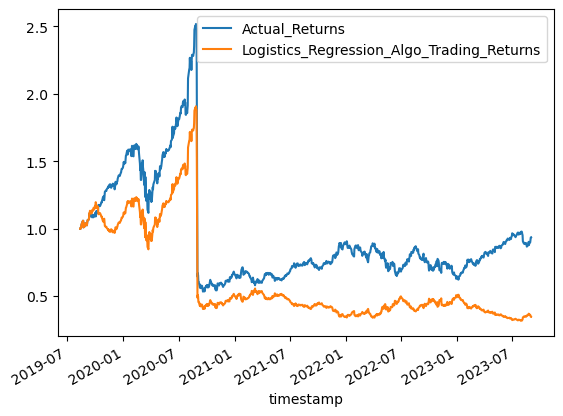

In [137]:
# Plot the actual returns versus the strategy returns
cum_return_plot_lr = (1 + lr_predict_df[['Actual_Returns', 'Logistics_Regression_Algo_Trading_Returns']]).cumprod().plot()
 
# Save figure
cum_return_plot_lr.get_figure().savefig("Cum_Ret_Logistic_Regression.png")

In [138]:
#Mean Absolute Error (MAE) 

from sklearn.metrics import mean_absolute_error 
actual_lr = lr_predict_df['Actual_Returns']
predicted_lr = lr_predict_df['Logistics_Regression_Algo_Trading_Returns'] 
# Calculate MAE mae = 
mae_lr = mean_absolute_error(actual_lr, predicted_lr) 
#Print the result 
print(f"Mean Absolute Error (MAE): {mae_lr}")

Mean Absolute Error (MAE): 0.01730256541857406


In [139]:
# Create a list for the column names

columns = ["Apple_Backtest_Performance_Metrics"]

# Create a list holding the names of the new evaluation metrics

metrics = [
    "Annualized_Returns",
    "Cumulative_Returns",
    "Annual_Volatility",
    "Sharpe_Ratio",
    "Sortino_Ratio",
    "Mean_Absolute_Error"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
aapl_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the sample DataFrame
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,NaN
Cumulative_Returns,NaN
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,NaN


In [140]:
# Pass the MAE into the DataFrame
aapl_evaluation_df.loc["Mean_Absolute_Error"] = mae_lr

In [141]:
# Calculate Metrics
aapl_evaluation_df.loc["Annualized_Returns"] = (
    aapl_signals_df['Actual_Returns'].mean() * 252
)

# Review the result
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,0.178829
Cumulative_Returns,NaN
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,0.017303


In [142]:
# Calculate the portfolio cumulative returns
aapl_evaluation_df.loc["Cumulative_Returns"] =  aapl_signals_df["Cumulative_Returns"][-1]

# Preview the DataFrame
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,0.178829
Cumulative_Returns,-0.074076
Annual_Volatility,NaN
Sharpe_Ratio,NaN
Sortino_Ratio,NaN
Mean_Absolute_Error,0.017303


In [152]:
# Calculate the annual volatility
aapl_evaluation_df.loc['Annual_Volatility'] = (
    aapl_signals_df['Actual_Returns'].std() * np.sqrt(252)
)

# Preview the DataFrame
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,0.178829
Cumulative_Returns,-0.074076
Annual_Volatility,0.487395
Sharpe_Ratio,0.366907
Sortino_Ratio,0.437685
Mean_Absolute_Error,0.017303


In [153]:
# Calculate Sharpe Ratio
aapl_evaluation_df.loc['Sharpe_Ratio'] = (
    aapl_signals_df['Actual_Returns'].mean() * 252) / (
    aapl_signals_df['Actual_Returns'].std() * np.sqrt(252)
)

# Preview the DataFrame
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,0.178829
Cumulative_Returns,-0.074076
Annual_Volatility,0.487395
Sharpe_Ratio,0.366907
Sortino_Ratio,0.437685
Mean_Absolute_Error,0.017303


In [154]:
# Sortino Ratio Calculation 
sortino_ratio_df =  aapl_signals_df[["Actual_Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:, "Downside_Returns"] = 0

# Find Portfolio Daily Returns values than 0,
# Square those values, and add them to the Downside_Returns column
sortino_ratio_df.loc[sortino_ratio_df["Actual_Returns"] < 0,
                     "Downside_Returns"] = sortino_ratio_df["Actual_Returns"]**2
                                                            
# Review the DataFrame
sortino_ratio_df.tail()

,Actual_Returns,Downside_Returns
timestamp,,
2023-08-25 04:00:00+00:00,0.012643,0.0
2023-08-28 04:00:00+00:00,0.008846,0.0
2023-08-29 04:00:00+00:00,0.021810,0.0
2023-08-30 04:00:00+00:00,0.019172,0.0
2023-08-31 04:00:00+00:00,0.001172,0.0


In [155]:
# Calculate the annual downside standard deviation value
downside_standard_deviation = (
    np.sqrt(sortino_ratio_df["Downside_Returns"].mean()) * np.sqrt(252)
)

print(f"Annual Downside Standard Deviation: {downside_standard_deviation}")

Annual Downside Standard Deviation: 0.42159092377329493


In [156]:
# The Sortino Ratio is reached by dividing the annualized return value by the downside standard deviation 
sortino_ratio = (aapl_evaluation_df.loc["Annualized_Returns"] / downside_standard_deviation)

# Add the Sortino Ratio to the evaluation metric
aapl_evaluation_df.loc['Sortino_Ratio'] = sortino_ratio

# Review the entire DataFrame
aapl_evaluation_df

,Apple_Backtest_Performance_Metrics
Annualized_Returns,0.178829
Cumulative_Returns,-0.074076
Annual_Volatility,0.487395
Sharpe_Ratio,0.366907
Sortino_Ratio,0.424176
Mean_Absolute_Error,0.017303


In [166]:
# Reorganized the df_aapl DataFrame for the MCSimulation 
appl_ticker_data_df = pd.concat([df_aapl], axis=1, keys=['AAPL'])

# Display the sample data
appl_ticker_data_df

AAPL                                     \
                              open    high      low   close    volume   
timestamp                                                               
2018-09-04 04:00:00+00:00  228.410  229.18  226.630  228.36  27423279   
2018-09-05 04:00:00+00:00  228.990  229.67  225.100  226.87  33395928   
2018-09-06 04:00:00+00:00  226.230  227.35  221.300  223.10  34291286   
2018-09-07 04:00:00+00:00  221.750  225.37  220.710  221.30  37678646   
2018-09-10 04:00:00+00:00  220.950  221.85  216.470  218.33  39516998   
...                            ...     ...      ...     ...       ...   
2023-08-25 04:00:00+00:00  177.380  179.15  175.820  178.61  50888986   
2023-08-28 04:00:00+00:00  180.090  180.59  178.545  180.19  43873741   
2023-08-29 04:00:00+00:00  179.695  184.90  179.500  184.12  53097997   
2023-08-30 04:00:00+00:00  184.940  187.85  184.740  187.65  60851143   
2023-08-31 04:00:00+00:00  187.840  189.12  187.480  187.87  60794516   

                                                          
                          trade_count        vwap symbol  
timestamp                                                 
2018-09-04 04:00:00+00:00      221428  228.110031   AAPL  
2018-09-05 04:00:00+00:00      265329  227.217795   AAPL  
2018-09-06 04:00:00+00:00      281785  223.575255   AAPL  
2018-09-07 04:00:00+00:00      302908  223.163961   AAPL  
2018-09-10 04:00:00+00:00      349539  218.276424   AAPL  
...                               ...         ...    ...  
2023-08-25 04:00:00+00:00      547380  177.911565   AAPL  
2023-08-28 04:00:00+00:00      533512  179.659469   AAPL  
2023-08-29 04:00:00+00:00      577653  183.281403   AAPL  
2023-08-30 04:00:00+00:00      637412  186.930379   AAPL  
2023-08-31 04:00:00+00:00      554869  188.148910   AAPL  

[1257 rows x 8 columns]

In [179]:
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

In [167]:
from MCForecastTools import MCSimulation 
MC_twoyear = MCSimulation (
    portfolio_data = appl_ticker_data_df,
    num_simulation = 500,
    num_trading_days = 252*2
)


In [168]:
MC_twoyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 110.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 120.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 130.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 140.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 150.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 160.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 170.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 180.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 190.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 200.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 210.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 220.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 230.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 240.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 250.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 260.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 270.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 280.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 290.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 300.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 310.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 320.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 330.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 340.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 350.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 360.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 370.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 380.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 390.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 400.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 410.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 420.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 430.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 440.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 450.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 460.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 470.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 480.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

Running Monte Carlo simulation number 490.


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCFor

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.979951,0.983533,0.945621,1.027513,0.982663,0.994491,0.989200,0.992183,0.999507,0.986330,...,0.999116,0.971839,0.996940,1.028267,1.047619,1.009132,1.025046,1.012686,0.980103,1.021634
2,1.022429,0.960220,0.934853,1.013888,0.936160,0.996472,1.003910,1.025124,1.021026,1.011131,...,1.014078,0.932236,1.016328,0.981592,1.031826,1.006670,1.035078,1.083692,0.986233,0.990036
3,1.014572,0.932920,0.934425,0.987365,0.968029,1.007482,0.970545,1.025196,1.027532,1.006350,...,1.021711,0.919901,1.069003,0.920611,1.050282,1.024215,1.050072,1.101761,1.054452,0.975678
4,1.046236,0.892834,0.928124,0.992682,0.975349,1.002869,0.953236,1.033286,1.028158,1.044836,...,1.026626,0.902086,1.062842,0.950853,1.017154,0.992892,1.065178,1.083592,1.058908,0.994596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.497109,0.657821,1.301482,1.297658,0.504350,0.493673,1.469738,2.197559,1.182141,2.833289,...,2.652381,0.720151,3.485241,0.829149,0.318869,0.614199,0.647432,0.363435,0.913124,0.931662
501,0.482002,0.636077,1.272735,1.295351,0.486266,0.513036,1.426071,2.294741,1.192578,2.999108,...,2.577370,0.746533,3.365860,0.837058,0.333246,0.592070,0.633126,0.367803,0.862157,0.967925
502,0.446448,0.660310,1.260744,1.301145,0.500869,0.514329,1.532451,2.430053,1.229935,2.904081,...,2.560610,0.771588,3.260771,0.850589,0.324437,0.581175,0.607080,0.371333,0.879614,0.937943
503,0.435153,0.653877,1.295853,1.294336,0.506045,0.511549,1.552324,2.180515,1.136098,2.958330,...,2.544400,0.763080,3.172692,0.869215,0.319873,0.576695,0.579576,0.347262,0.909567,0.956186


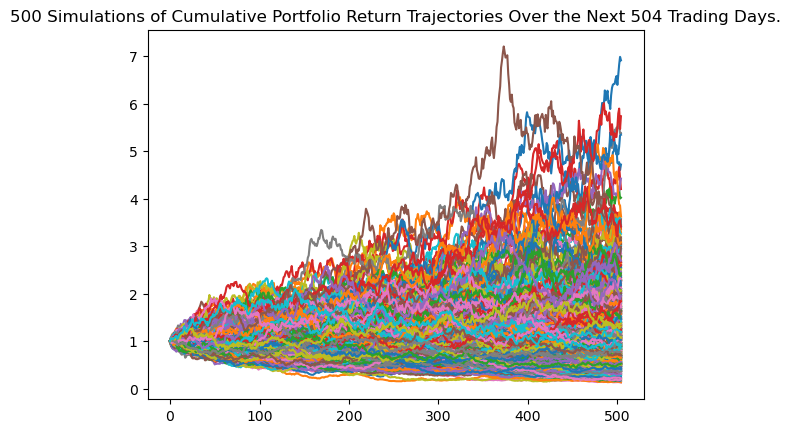

In [171]:
# Plot MCSimulation 
aapl_line_plot = MC_twoyear.plot_simulation()

In [175]:
# Compute summary statistics from simulated daily returns
aapl_simulated_returns_data = {
    "mean": list(MC_twoyear.simulated_return.mean(axis =1)),
    "median": list(MC_twoyear.simulated_return.median(axis =1)),
    "min": list(MC_twoyear.simulated_return.min(axis =1)),
    "max": list(MC_twoyear.simulated_return.max(axis =1))
}
# Create a DataFrame with the Summary Stats
df_aapl_simulated_returns = pd.DataFrame(aapl_simulated_returns_data)

# Display the sample data
df_aapl_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001752,0.999981,0.902720,1.086807
2,1.002844,1.000873,0.867496,1.136734
3,1.004121,1.002592,0.838523,1.161608
4,1.004390,1.003625,0.831691,1.169606


<Axes: title={'center': 'Apple Daily Returns Simulated Over the Next Two Years'}>

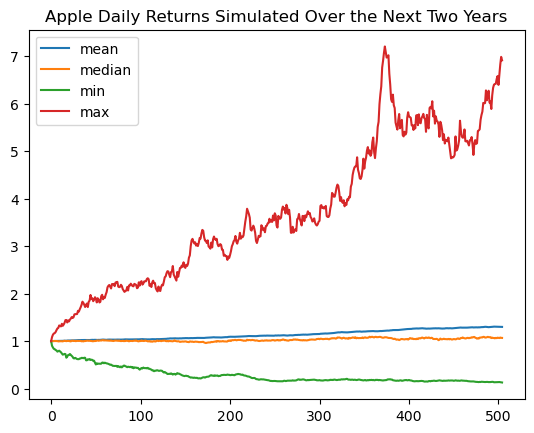

In [176]:
# Plot the simulated returns over the next 2 years
df_aapl_simulated_returns.plot(title = "Apple Daily Returns Simulated Over the Next Two Years")


In [180]:
tbl = MC_twoyear.summarize_cumulative_return()

print(tbl)

count           500.000000
mean              1.300614
std               0.898529
min               0.130494
25%               0.682217
50%               1.068793
75%               1.656363
max               6.914126
95% CI Lower      0.277925
95% CI Upper      3.431989
Name: 504, dtype: float64


C:\Users\chain\OneDrive\Documents\FinTech BootCamp\Projects\Project2\RESOURCES\Apple\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)
